MovieWriter imagemagick unavailable; using Pillow instead.


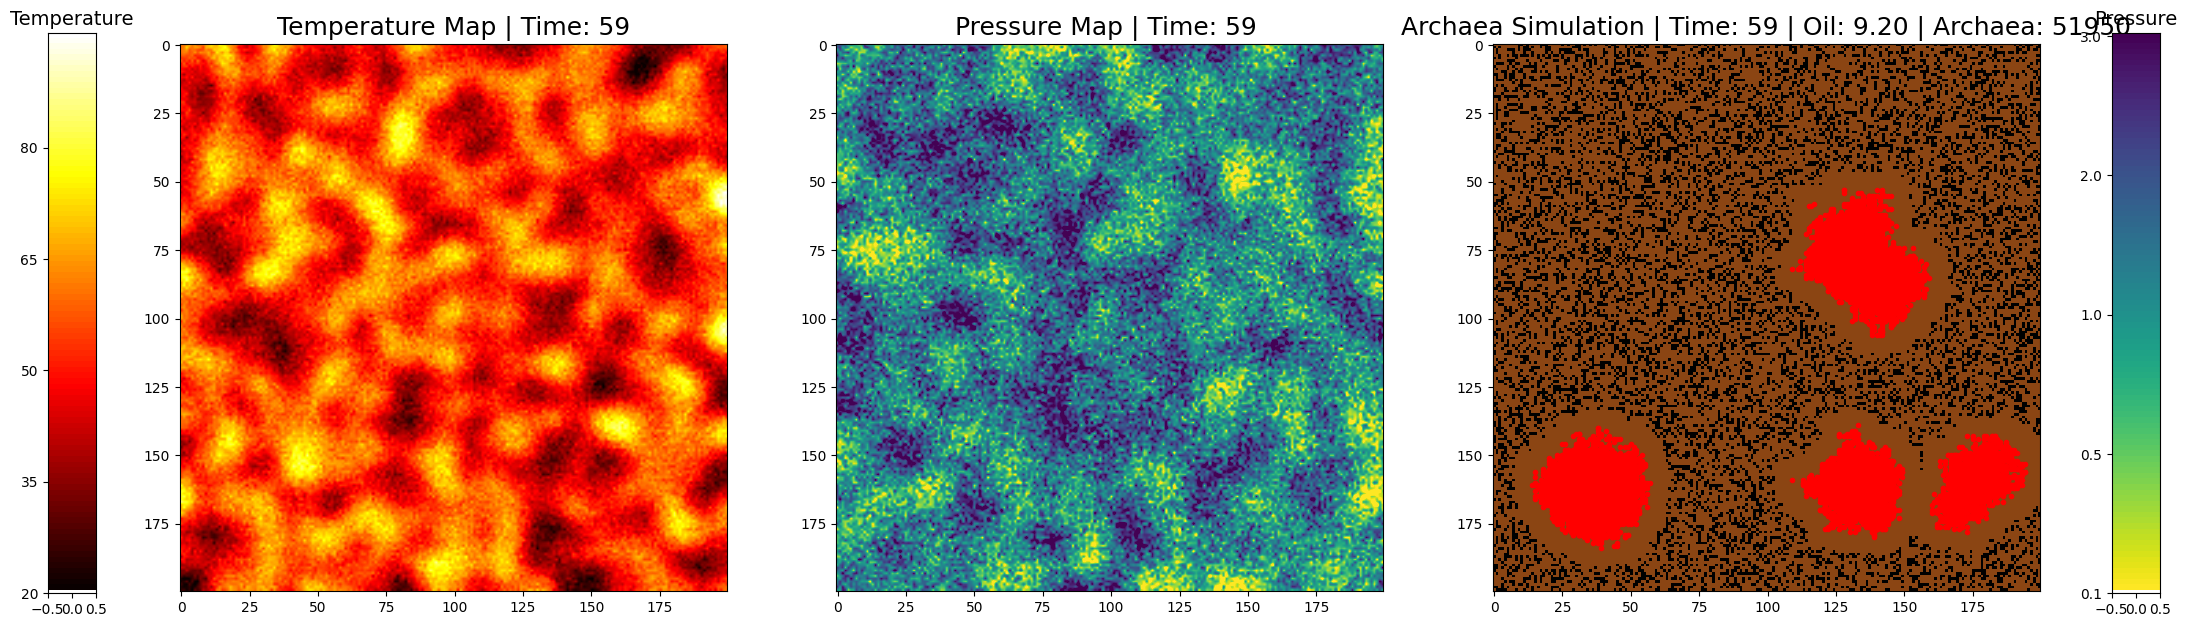

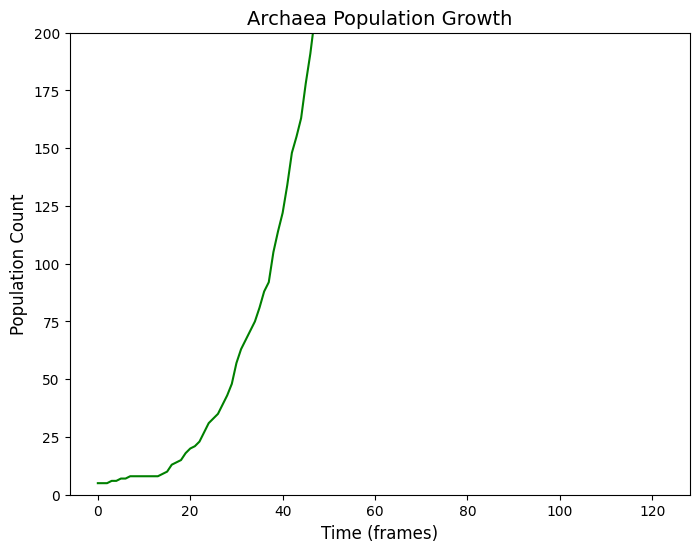

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.animation as animation
import random
from scipy.ndimage import gaussian_filter

# Parameters
GRID_SIZE = 200  # Size of the grid
INITIAL_ARCHEA_COUNT = 5  # Initial number of archaea
OIL_DENSITY = 0.3  # Oil density in the grid (0-1)
ARCHEA_MOVEMENT_PROBABILITY = 0.5  # Probability of archaea movement
ARCHEA_REPRODUCTION_PROBABILITY = 0.1  # Probability of archaea reproduction
CONSUMPTION_RADIUS = 6  # Radius of oil consumption around archaea
STARVATION_FRAMES = 20  # Frames without oil before archaea die

# Conditions for archaea survival
OPTIMAL_TEMPERATURE = (30, 60)  # Optimal temperature in Celsius
OPTIMAL_PRESSURE = (0.5, 2)  # Optimal pressure in atmospheres

# Create grid
grid = np.random.rand(GRID_SIZE, GRID_SIZE) < OIL_DENSITY  # Oil grid
temperature_map = gaussian_filter(np.random.uniform(20, 80, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Temperature from 20 to 80°C
pressure_map = gaussian_filter(np.random.uniform(0.1, 3, (GRID_SIZE, GRID_SIZE)), sigma=5)  # Pressure from 0.1 to 3 atm

# Function to initialize positions of archaea based on oil density and conditions
def initialize_archea_positions(initial_count, grid, temperature_map, pressure_map):
    oil_density_map = np.zeros_like(grid, dtype=float)

    # Calculate oil density around each cell
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if grid[x, y]:  # If there is oil
                for dx in range(-1, 2):
                    for dy in range(-1, 2):
                        if 0 <= x + dx < GRID_SIZE and 0 <= y + dy < GRID_SIZE:
                            oil_density_map[x + dx, y + dy] += 1

    # Get positions with maximum oil density
    oil_positions = np.argwhere(oil_density_map > 0)

    # Filter positions by temperature and pressure conditions
    suitable_positions = []
    for pos in oil_positions:
        x, y = pos
        if (OPTIMAL_TEMPERATURE[0] <= temperature_map[x, y] <= OPTIMAL_TEMPERATURE[1] and
                OPTIMAL_PRESSURE[0] <= pressure_map[x, y] <= OPTIMAL_PRESSURE[1]):
            suitable_positions.append(pos)

    # If not enough suitable positions, raise an error
    if len(suitable_positions) == 0:
        raise ValueError("No suitable positions for spawning archaea.")

    # Randomly select unique initial positions from suitable positions
    selected_indices = np.random.choice(len(suitable_positions), size=min(initial_count, len(suitable_positions)), replace=False)
    return np.array(suitable_positions)[selected_indices]

# Initialize positions of archaea
archea_positions = initialize_archea_positions(INITIAL_ARCHEA_COUNT, grid, temperature_map, pressure_map)

# Create figure and axes for animation
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
ax1.set_title("Temperature Map", fontsize=14)
ax2.set_title("Pressure Map", fontsize=14)
ax3.set_title("Archaea Simulation", fontsize=14)
cmap_temp = plt.get_cmap('hot')  # Colors for temperature (warm palette)
cmap_archea = ListedColormap(['saddlebrown', 'black'])  # Colors for archaea

# Display temperature map
temp_plot = ax1.imshow(temperature_map, cmap=cmap_temp, interpolation='bilinear')

# Display pressure map
pressure_plot = ax2.imshow(pressure_map, interpolation='bilinear')

# Display grid with oil and archaea
oil_plot = ax3.imshow(grid, cmap=cmap_archea, interpolation='nearest')
archea_plot, = ax3.plot(archea_positions[:, 1], archea_positions[:, 0], 'ro', markersize=3)

# Add color bars for temperature and pressure
temp_bar = fig.add_axes([0.07, 0.15, 0.02, 0.7])
temp_bar.set_title("Temperature", fontsize=14)
temp_bar.imshow(np.linspace(80, 20, 100).reshape(100, 1), cmap=cmap_temp, aspect='auto')
temp_bar.set_yticks([100, 80, 60, 40, 20])
temp_bar.set_yticklabels([20, 35, 50, 65, 80])

pressure_bar = fig.add_axes([0.93, 0.15, 0.02, 0.7])
pressure_bar.set_title("Pressure", fontsize=14)
pressure_bar.imshow(np.linspace(0.1, 3, 100).reshape(100, 1), aspect='auto')
pressure_bar.set_yticks([100, 75, 50, 25, 0])
pressure_bar.set_yticklabels([0.1, 0.5, 1.0, 2.0, 3.0])

# Add starvation and health counters for each archaea
starvation_counters = np.zeros(len(archea_positions), dtype=int)
health_counters = np.zeros(len(archea_positions), dtype=int)  # Health counter

# List to track population over time
population_history = []

# Function to calculate and display statistics
def calculate_statistics(grid, archea_positions):
    oil_count = np.sum(grid)  # Count of oil
    archaea_count = len(archea_positions)  # Count of archaea
    return oil_count, archaea_count

# Function to update the animation frame
def animate(frame):
    global archea_positions, grid, temperature_map, pressure_map, starvation_counters, health_counters, population_history

    # Update temperature and pressure maps with smooth animation
    temperature_map += np.random.uniform(-0.5, 0.5, (GRID_SIZE, GRID_SIZE)) / 10
    pressure_map += np.random.uniform(-0.1, 0.1, (GRID_SIZE, GRID_SIZE)) / 10

    # Update temperature map display
    temp_plot.set_array(temperature_map)

    # Update pressure map display
    pressure_plot.set_array(pressure_map)

    # Check survival conditions for archaea
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        if (temperature_map[x, y] < OPTIMAL_TEMPERATURE[0] or temperature_map[x, y] > OPTIMAL_TEMPERATURE[1] or
                pressure_map[x, y] < OPTIMAL_PRESSURE[0] or pressure_map[x, y] > OPTIMAL_PRESSURE[1]):
            health_counters[i] += 1  # Increase health counter
        else:
            health_counters[i] = 0  # Reset health counter

    # Remove archaea if health deteriorates
    dead_archea_indices = np.where(health_counters >= 10)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Move archaea
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_MOVEMENT_PROBABILITY:
            # Choose a random direction
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Move right
                x += 1
            elif direction == 1 and x > 0:  # Move left
                x -= 1
            elif direction == 2 and y < GRID_SIZE - 1:  # Move down
                y += 1
            elif direction == 3 and y > 0:  # Move up
                y -= 1
            archea_positions[i] = (x, y)

    # Reproduction of archaea
    new_archea_positions = []
    for i, (x, y) in enumerate(archea_positions):
        if random.random() < ARCHEA_REPRODUCTION_PROBABILITY:
            # Choose a random direction for new archaea
            direction = random.randint(0, 3)
            if direction == 0 and x < GRID_SIZE - 1:  # Move right
                new_archea_positions.append((x + 1, y))
            elif direction == 1 and x > 0:  # Move left
                new_archea_positions.append((x - 1, y))
            elif direction == 2 and y < GRID_SIZE - 1:  # Move down
                new_archea_positions.append((x, y + 1))
            elif direction == 3 and y > 0:  # Move up
                new_archea_positions.append((x, y - 1))

    new_archea_positions = np.array(new_archea_positions)
    if new_archea_positions.size > 0:
        archea_positions = np.vstack((archea_positions, new_archea_positions))
        starvation_counters = np.append(starvation_counters, np.zeros(len(new_archea_positions), dtype=int))
        health_counters = np.append(health_counters, np.zeros(len(new_archea_positions), dtype=int))

    # Oil consumption around archaea
    for i in range(len(archea_positions)):
        x, y = archea_positions[i]
        found_oil = False
        for dx in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
            for dy in range(-CONSUMPTION_RADIUS, CONSUMPTION_RADIUS + 1):
                nx = x + dx
                ny = y + dy
                if 0 <= nx < GRID_SIZE and 0 <= ny < GRID_SIZE and grid[nx, ny]:
                    grid[nx, ny] = False
                    found_oil = True
                    break
            if found_oil:
                break
        if found_oil:
            starvation_counters[i] = 0
        else:
            starvation_counters[i] += 1

    dead_archea_indices = np.where(starvation_counters >= STARVATION_FRAMES)[0]
    if dead_archea_indices.size > 0:
        archea_positions = np.delete(archea_positions, dead_archea_indices, axis=0)
        starvation_counters = np.delete(starvation_counters, dead_archea_indices)
        health_counters = np.delete(health_counters, dead_archea_indices)

    # Update display of oil grid and archaea
    oil_plot.set_data(grid)
    archea_plot.set_data(archea_positions[:, 1], archea_positions[:, 0])

    # Statistics
    stats = calculate_statistics(grid, archea_positions)
    ax1.set_title(f"Temperature Map | Time: {frame}", fontsize=18)
    ax2.set_title(f"Pressure Map | Time: {frame} ", fontsize=18)
    ax3.set_title(f"Archaea Simulation | Time: {frame} | Oil: {stats[0] / 1000:.2f} | Archaea: {stats[1]}", fontsize=18)

    # Update population history
    population_history.append(len(archea_positions))
    return temp_plot, pressure_plot, oil_plot, archea_plot

# Create figure and axes for population growth graph
fig2, ax5 = plt.subplots(figsize=(8, 6))
ax5.set_title("Archaea Population Growth", fontsize=14)
ax5.set_xlabel("Time (frames)", fontsize=12)
ax5.set_ylabel("Population Count", fontsize=12)
ax5.set_ylim(0, GRID_SIZE)  # Set y-axis limit based on grid size

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=60, interval=300, blit=True)
ani.save('animation.gif', writer='imagemagick')

# Display separate population growth graph
def update_population_graph():
    ax5.clear()
    ax5.plot(population_history, color='green')
    ax5.set_title("Archaea Population Growth", fontsize=14)
    ax5.set_xlabel("Time (frames)", fontsize=12)
    ax5.set_ylabel("Population Count", fontsize=12)
    ax5.set_ylim(0, GRID_SIZE)  # Set y-axis limit based on grid size
    plt.draw()

# Update the population graph in a loop
for frame in range(60):
    animate(frame)
    update_population_graph()

plt.show()